Численные методы  
Лабораторная работа 5

$ \dfrac{\partial u}{\partial t} = a \dfrac{\partial^2 u}{\partial x^2},~a>0$  
$ u(0,t) = 0$  
$ u(1,t) = 0$  
$ u(x,0) = \sin(2 \pi x)$

Решение: $u(x,t) = e^{-4\pi^2 a t} \sin(2 \pi x)$

Явная схема:

$\dfrac{u_j^{k+1} - u_j^k}{\tau} = a \dfrac{u_{j-1}^{k} - 2u_j^k + u_{j+1}^{k}}{h^2}$

$u_j^{k+1} = \sigma u_{j-1}^{k} + (1-2\sigma)u_j^k + \sigma u_{j+1}^{k}$

где $\sigma = \dfrac{a\tau}{h^2}$

Неявная схема:

$\dfrac{u_j^{k+1} - u_j^k}{\tau} = a \dfrac{u_{j-1}^{k+1} - 2u_j^{k+1} + u_{j+1}^{k+1}}{h^2}$

$a_j \cdot u_{j-1}^{k+1} + b_j \cdot u_{j}^{k+1} + c_j \cdot u_{j+1}^{k+1} = d_j$

где $a_j = -\sigma,~~b_j = 1+2\sigma,~~c_j = -\sigma,~~d_j = u_{j}^{k}$

Схема Кранка-Николсона:

$u_{xx}(x_j,t_k) = \theta a \dfrac{u_{j-1}^{k} - 2u_j^k + u_{j+1}^{k}}{h^2} + (1 - \theta) a \dfrac{u_{j-1}^{k+1} - 2u_j^{k+1} + u_{j+1}^{k+1}}{h^2}$

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def cond_1(t):
    return 0

def cond_2(t):
    return 0

def init_cond(x):
    return math.sin(2 * math.pi * x)

def analytical_solution(x, t, a = 1.0):
    return math.exp(-4 * math.pi * math.pi * a * t) * math.sin(2 * math.pi * x)

Явная схема:

In [3]:
l_start = 0.0
l_finish = 1.0
t_start = 0.0
t_finish = 1.0

def explicit(N = 30, K = 300, a = 1.0, theta = 0.0):
    N = N - 1
    K = K - 1
    h = (l_finish - l_start) / N
    tau = (t_finish - t_start) / K
    sigma = a * a * tau / (h * h)
    X = []
    Y = []
    ans = []
    
    x = list(np.arange(l_start, l_finish + h/2, h))
    last_line = list(map(init_cond, x))
    ans.append(list(last_line))
    X.append(x)
    Y.append([0.0 for _ in x])
    
    for t in np.arange(t_start + tau, t_finish + tau/2, tau):
        ans_line = [None for _ in last_line]
        for i in range(1, len(x) - 1):
            ans_line[i] = sigma * last_line[i - 1]
            ans_line[i] += (1 - 2 * sigma) * last_line[i]
            ans_line[i] += sigma * last_line[i + 1]
        ans_line[0] = cond_1(t)
        ans_line[-1] = cond_2(t)
        
        ans.append(ans_line)
        X.append(x)
        Y.append([t for _ in x])
        last_line = ans[-1]
    
    return X, Y, ans

Схема Кранка-Николсона:

Метод прогонки:

In [4]:
def race_method(A, b):
    P = [-item[2] for item in A]
    Q = [item for item in b]
    eps = 1e-10 if abs(A[0][1]) < 1e-8 else 0
    P[0] /= (A[0][1] + eps)
    Q[0] /= (A[0][1] + eps)
    for i in range(1, len(b)):
        z = (A[i][1] + A[i][0] * P[i-1])
        P[i] /= (z + eps)
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= (z + eps)
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    return x

In [5]:
l_start = 0.0
l_finish = 1.0
t_start = 0.0
t_finish = 1.0

def unexplicit(N = 30, K = 300, a = 1.0, theta = 0.5):
    N = N - 1
    K = K - 1
    h = (l_finish - l_start) / N
    tau = (t_finish - t_start) / K
    sigma = a * a * tau / (h * h)
    X = []
    Y = []
    ans = []
    
    x = list(np.arange(l_start, l_finish + h/2, h))
    last_line = list(map(init_cond, x))
    ans.append(list(last_line))
    X.append(x)
    Y.append([0.0 for _ in x])
    
    for t in np.arange(t_start + tau, t_finish + tau/2, tau):
        coeff_a = sigma * theta
        coeff_b = -1 - 2 * sigma * theta
        
        A = [
            (coeff_a, coeff_b, coeff_a)
            for _ in range(1, len(x)-1)
        ]
        coeff_d = [
            -(last_line[i] + (1 - theta) * sigma* (last_line[i-1] - 2*last_line[i] + last_line[i+1])) 
            for i in range(1, len(x)-1)
        ]
        A.insert(0, (0,0,cond_1(0)))
        coeff_d.insert(0, cond_1(0))
        
        A.append((0,0,cond_2(0)))
        coeff_d.append(cond_2(0))
        
        ans.append(race_method(A, coeff_d))
        X.append(x)
        Y.append([t for _ in x])
        last_line = ans[-1]
    
    return X, Y, ans

Вычисление невязки:

In [6]:
def MSE(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return (ans / (len(z) * len(z[0])))**0.5

In [7]:
def error_plot(solver, name_solver, real_f, theta = 0.5):
    h = []
    e = []
    for N in range(5, 30):
        x, t, ans = solver(N=N, K = 100*N*N, theta=theta, a=1.0)
        h.append(1.0 / N)
        e.append(MSE(x, t, ans, real_f))
    
    plt.title("Зависимость погрешности от длины шага по x и по t")
    plt.plot(h, e, label=name_solver, color = "red")
    plt.xlabel("h")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid()

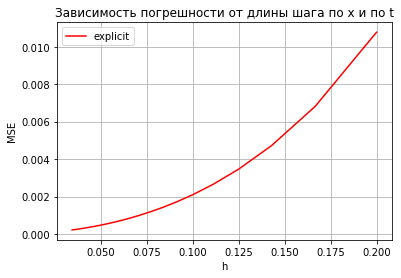

In [8]:
error_plot(explicit, "explicit", analytical_solution, 0.0)

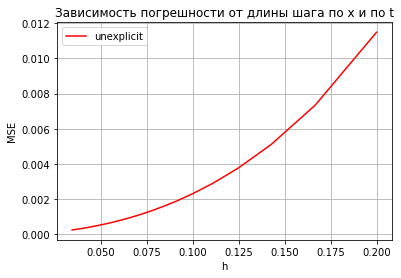

In [9]:
error_plot(unexplicit, "unexplicit", analytical_solution, 1.0)

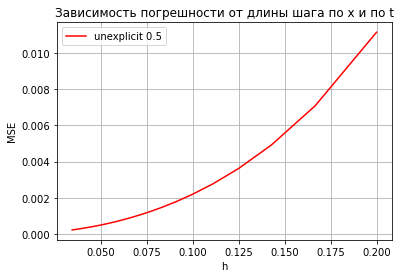

In [10]:
error_plot(unexplicit, "unexplicit 0.5", analytical_solution, 0.5)

In [11]:
def R3_plot(N = 10, K = 200, theta = 0.0, method=analytical_solution, method_name='explicit'):
    X_e, Y_e, Z_e = method(N = N, K = K, theta = theta)
    U = []
    r = 10
    for i in range(0, len(X_e[r]), 1):
        U.append(analytical_solution(X_e[r][i], Y_e[r][i]))
    plt.plot(U, label="alalytical")
    plt.plot(Z_e[r], label=method_name)
    plt.legend()

    print('MSE =', MSE(X_e, Y_e, Z_e, analytical_solution))

MSE = 0.00046322728504919137


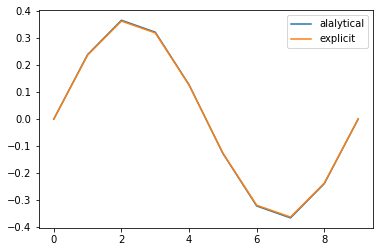

In [12]:
R3_plot(10, 400, 0, explicit, 'explicit')

MSE = 0.0022273328800357555


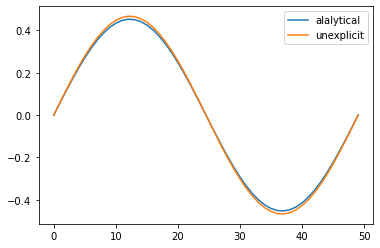

In [13]:
R3_plot(50, 500, 1.0, unexplicit, 'unexplicit')

MSE = 4.730411911666352e-05


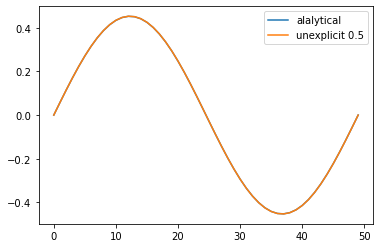

In [14]:
R3_plot(50, 500, 0.5, unexplicit, 'unexplicit 0.5')